import requests
import pandas as pd

fechaini = '09/01/2022'
fechafin = '12/21/2022'
ticker = 'BAC'
ndays =  '20'
prepost = 'false'
minute = '5m'

url = f'https://query1.finance.yahoo.com/v8/finance/chart/{ticker}?range={ndays}d&includePrePost={prepost}&interval={minute}&corsDomain=finance.yahoo.com&.tsrc=finance'
headers = {
'User-Agent':
'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36'}
r = requests.get(url, headers=headers)
r.json()['chart']['result'][0]['meta'].keys()

In [1]:
tickers='MSFT'
period="50d"
interval='5m'

In [2]:
import yfinance as yf
import plotly.graph_objects as go
from datetime import date
import pandas as pd
#%matplotlib
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from datetime import time
#msft = yf.Ticker("MSFT")
#msft.info


In [3]:
data = yf.download(tickers=tickers, period=period, interval=interval)
print(data.shape)

[*********************100%***********************]  1 of 1 completed
(3857, 6)


In [4]:
# Drop incomplete dates series
data['daysTime'] = data.index.time
data['dates'] = data.index.date

g = data.groupby(['dates'])['daysTime'].agg(['min','max'])
drop_dates = g.loc[g['max'] < time(15,55)].index.values
data = data[~(data['dates'].isin(drop_dates.tolist()))]

# Avoid auction's bar and 16hs bar
data = data[~(data['daysTime'].isin([time(9,30),time(15,55),time(16,0)]))]
t_data = data[data['dates'].isin([data['dates'].max()])]
data.shape


(3648, 8)

In [5]:
df_d=data.groupby('dates')['dates'].count()
drop_dates.tolist()


[datetime.date(2023, 7, 3), datetime.date(2023, 8, 16)]

In [6]:
data['typical_price'] = data[['High', 'Low', 'Close']].mean(axis=1)
data['typical_price_w'] = data[['High', 'Low', 'Close']].mean(axis=1) * data['Volume']
VWAP_d = data.groupby(['dates'])['typical_price_w','Volume'].sum() #/ data.groupby(['dates'])['Volume'].sum()
VWAP_d['vwap'] = VWAP_d['typical_price_w'] / VWAP_d['Volume']
# Average volumen by interval
avgvol = data.groupby(['daysTime'])['Volume'].mean()
percvol = data.groupby(['daysTime'])['Volume'].sum()/data.Volume.sum()

# Merge with last date data to compare average volume with last day volumen by interval 
t_data = t_data.merge(avgvol, left_on='daysTime', right_on='daysTime')
t_data['typical_price_w_y'] = t_data[['High', 'Low', 'Close']].mean(axis=1) * t_data['Volume_y']
t_data['typical_price_w_x'] = t_data[['High', 'Low', 'Close']].mean(axis=1) * t_data['Volume_x']

# Compare efffective last day VWAP vs estimated volume VWAP
dayVWAP = t_data['typical_price_w_y'].sum()/t_data['Volume_y'].sum()
estimateVWAP = t_data['typical_price_w_x'].sum()/t_data['Volume_x'].sum()
error = 100 * (dayVWAP/estimateVWAP -1)
print('Effective VWAP ' + dayVWAP.__str__())
print('Estimated VWAP ' + estimateVWAP.__str__())
print('Error % VWAP ' + error.__str__())


Effective VWAP 323.30782032796645
Estimated VWAP 323.32638896472105
Error % VWAP -0.0057430006916714404


C:\Users\jljuncos\AppData\Local\Temp\ipykernel_7392\4100490092.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  VWAP_d = data.groupby(['dates'])['typical_price_w','Volume'].sum() #/ data.groupby(['dates'])['Volume'].sum()


In [7]:
# Plot volume pattern for full sample average volume
fig = px.line(x=avgvol[avgvol.values > 0].index, 
              y=[1]*avgvol[avgvol.values > 0].index.__len__(), 
              color=px.Constant("Price"),
              labels=dict(x="Time", y="Avg. Volume by time window", color="Time Interval"))


fig.add_bar(x=avgvol[avgvol.values > 0].index, y=avgvol[avgvol > 0], name="Average volume")
fig.show()

In [8]:
# Plot volume pattern for full sample percent of full sample total volume

fig = px.line(x=data.daysTime.unique(), y=[0]*data.daysTime.unique().__len__(), color=px.Constant(""),
             labels=dict(x="Time", y="Volume", color="Time Period"))
fig.add_bar(x=data.daysTime.unique(), y=percvol, name="Percent volume")
fig.show()

In [18]:
# Average volume in moving window
rol_avgvol = data.groupby(['daysTime']).rolling(20).Volume.mean()
rol_vol = data.groupby(['daysTime']).rolling(20).Volume.sum()

In [17]:
rol_vol = rol_vol.reset_index()
rol_vol.Datetime = rol_vol.Datetime.apply(lambda x : x.date())
cum_vol = rol_vol.groupby(['Datetime'])['Volume'].sum()
rol_merge = pd.merge(rol_vol, cum_vol, left_on='Datetime',right_on='Datetime',how='left')
rol_merge['perc_vol'] = 100 * rol_merge.Volume_x/rol_merge.Volume_y
rol_perc = rol_merge.dropna().pivot(columns='Datetime', index='daysTime', values='perc_vol')
rol_perc


Datetime,2023-07-06,2023-07-07,2023-07-10,2023-07-11,2023-07-12,2023-07-13,2023-07-14,2023-07-17,2023-07-18,2023-07-19,...,2023-08-02,2023-08-03,2023-08-04,2023-08-07,2023-08-08,2023-08-09,2023-08-10,2023-08-11,2023-08-14,2023-08-15
daysTime,,,,,,,,,,,,,,,,,,,,,
09:35:00,2.906388,2.912423,3.123124,3.106052,3.111201,3.293248,3.365076,3.413951,3.160181,3.188680,...,3.229987,3.211304,3.335328,3.279937,3.252003,3.206740,3.082039,3.008894,2.984794,3.224663
09:40:00,3.030384,3.023361,3.209928,3.147733,3.101556,3.173536,3.056822,3.111671,2.771301,2.717026,...,2.633700,2.549608,2.612059,2.527321,2.494528,2.455568,2.391491,2.384446,2.367011,2.551235
09:45:00,2.693520,2.718871,2.896432,2.846972,2.879472,2.911595,2.851409,2.983094,2.570406,2.549870,...,2.580050,2.537165,2.575664,2.492496,2.504848,2.395247,2.379117,2.377360,2.299994,2.500216
09:50:00,2.148882,2.148952,2.282173,2.296783,2.274831,2.257817,2.245858,2.326298,2.127249,2.065052,...,2.111426,2.135053,2.158801,2.100546,2.086326,2.050623,2.064921,2.060700,2.004826,2.187339
09:55:00,2.006750,2.016328,2.100547,2.090712,2.071486,2.062828,2.051249,2.145857,1.956930,1.905786,...,1.971555,2.002011,2.029841,1.980777,1.968868,1.921432,1.951655,1.930143,1.876294,2.060493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15:30:00,1.262727,1.274653,1.266005,1.281368,1.283588,1.285549,1.249014,1.256753,1.353615,1.325846,...,1.356703,1.369949,1.355293,1.364271,1.363948,1.367685,1.347794,1.368915,1.362222,1.330217
15:35:00,1.404329,1.432944,1.407500,1.406492,1.396256,1.380353,1.378130,1.387082,1.384711,1.364488,...,1.374969,1.387926,1.365458,1.363401,1.367407,1.369242,1.352911,1.356929,1.356793,1.311582
15:40:00,1.459081,1.459672,1.407965,1.415452,1.406017,1.412580,1.399311,1.416877,1.403829,1.348397,...,1.591225,1.613409,1.590396,1.595041,1.611505,1.643925,1.617158,1.643561,1.641363,1.675916


In [11]:
#rol_avgvol = rol_avgvol.dropna()
rol_avgvol = rol_avgvol.reset_index()
rol_avgvol['Datetime'] = rol_avgvol['Datetime'].apply(lambda x : x.date())
rol_avgvol['next_day'] = rol_avgvol['Datetime'].shift(-1)
rol_avgvol = pd.merge(rol_avgvol, data[['dates', 'daysTime', 'typical_price']], left_on=['next_day', 'daysTime'], right_on=['dates', 'daysTime'],how='left')
rol_avgvol['typical_price_w'] = rol_avgvol['typical_price'] * rol_avgvol['Volume']
rol_VWAP = rol_avgvol.groupby(['next_day'])['typical_price_w', 'Volume'].sum()
rol_VWAP['rol_VWAP_forecast'] = rol_VWAP['typical_price_w'] / rol_VWAP['Volume']
rol_VWAP = pd.merge(rol_VWAP,VWAP_d[['vwap']], left_index=True, right_index=True,how='inner')
rol_VWAP['forecast/vwap'] = 100*(rol_VWAP['rol_VWAP_forecast'] / rol_VWAP['vwap'] - 1)
rol_VWAP = rol_VWAP.dropna()
rol_VWAP


C:\Users\jljuncos\AppData\Local\Temp\ipykernel_7392\1381067003.py:7: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,typical_price_w,Volume,rol_VWAP_forecast,vwap,forecast/vwap
next_day,,,,,
2023-06-06,6.539034e+09,19597266.20,333.670712,333.636170,0.010353
2023-07-07,5.916757e+09,17416320.60,339.724834,339.710620,0.004184
2023-07-10,5.746430e+09,17383290.20,330.572059,330.486159,0.025992
2023-07-11,5.673940e+09,17175569.15,330.349462,330.338986,0.003171
2023-07-12,5.885189e+09,17394891.95,338.328585,338.402637,-0.021883
2023-07-13,6.024960e+09,17646103.45,341.432907,341.518288,-0.025001
2023-07-14,6.125756e+09,17622700.20,347.605959,347.912682,-0.088161
2023-07-17,6.162214e+09,17850439.45,345.213557,345.151704,0.017921
2023-07-18,6.225974e+09,17596479.35,353.819325,358.553546,-1.320366


In [12]:
pvt_rol_avgvol = rol_avgvol.dropna().pivot(columns='Datetime', index='daysTime', values='Volume')
pvt_rol_avgvol

Datetime,2023-07-06,2023-07-07,2023-07-10,2023-07-11,2023-07-12,2023-07-13,2023-07-14,2023-07-17,2023-07-18,2023-07-19,...,2023-08-02,2023-08-03,2023-08-04,2023-08-07,2023-08-08,2023-08-09,2023-08-10,2023-08-11,2023-08-14,2023-08-15
daysTime,,,,,,,,,,,,,,,,,,,,,
09:35:00,506185.85,506275.00,536414.40,540294.45,549005.75,580359.20,600680.80,600735.10,596320.10,616716.10,...,788555.80,771656.60,807293.10,772214.25,758073.00,736117.20,706385.25,679332.30,671655.60,656450.15
09:40:00,527781.40,525559.65,551323.35,547544.70,547303.80,559262.80,545656.20,547544.55,522939.05,525494.45,...,642980.75,612655.20,632230.70,595021.55,581498.45,563683.35,548115.60,538347.75,532638.50,519359.15
09:45:00,469112.05,472629.15,497478.60,495227.75,508114.60,513101.65,508988.95,524919.55,485030.70,493165.20,...,629882.80,609665.10,623421.70,586822.60,583904.15,549836.50,545279.65,536747.90,517558.00,508973.20
09:50:00,374256.15,373558.60,391976.25,399523.00,401418.95,397888.25,400895.60,409346.50,401407.70,399397.40,...,515474.85,513040.20,522522.85,494543.50,486342.60,470726.80,473267.75,465254.05,451137.55,445280.30
09:55:00,349502.00,350504.15,360780.85,363677.05,365536.65,363526.05,366156.90,377595.30,369268.85,368594.10,...,481327.35,481070.85,491308.85,466345.70,458962.10,441070.75,447307.80,435777.50,422214.55,419458.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15:30:00,219920.65,221576.70,217443.50,222892.55,226503.20,226548.50,222954.40,221144.30,255424.55,256429.25,...,331219.85,329190.45,328039.30,321198.15,317949.35,313956.25,308906.50,309066.45,306535.10,270794.55
15:35:00,244582.45,249092.75,241746.15,244657.75,246384.75,243255.45,246002.30,244077.65,261292.25,263902.75,...,335679.25,333510.15,330499.60,320993.20,318755.60,314313.80,310079.15,306360.35,305313.50,267001.05
15:40:00,254118.25,253739.00,241826.05,246216.35,248107.30,248934.80,249783.10,249320.45,264899.80,260790.70,...,388475.05,387692.30,384944.25,375529.65,375657.20,377368.10,370643.10,371074.65,369349.05,341169.15


In [13]:

z=data.pivot(index='daysTime', columns='dates', values='Volume').values
x=data.dates.unique()
y=data.daysTime.unique()
fig = go.Figure(data=[go.Surface(z=z,x=x, y=y)])
fig.show()


C:\Users\jljuncos\AppData\Local\Temp\ipykernel_7392\2744949260.py:29: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\jljuncos\AppData\Local\Temp\ipykernel_7392\2744949260.py:30: UserWarning:

FixedFormatter should only be used together with FixedLocator



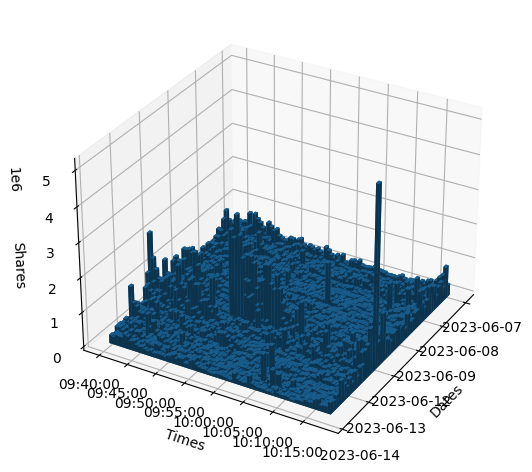

In [14]:
#%matplotlib
fig = plt.figure(figsize=(15, 6), dpi=100)
ax = plt.axes(projection = "3d")
numOfCols = x.__len__()
numOfRows = y.__len__()

 
xpos = np.arange(0, numOfCols, 1)
ypos = np.arange(0, numOfRows, 1)
xpos, ypos = np.meshgrid(xpos, ypos)
 
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros(numOfCols * numOfRows)
 
dx = np.ones(numOfRows * numOfCols)
dy = np.ones(numOfCols * numOfRows)
dz = data.pivot(index='daysTime', columns='dates', values='Volume').fillna(0).values.flatten()
 
ax.bar3d(xpos, ypos, zpos, dx, dy, dz)
#xlabel = data['dates'].apply(lambda x: x.strftime('%m/%d/%Y')).unique()
#ylabel = data['daysTime'].apply(lambda x: x.strftime('%H:%M')).sort_values().unique()
#ax.set_yticks(np.arange(1,list(range(1,ylabel.__len__(),5)).__len__()+1,1))
#ax.set_xticks(np.arange(1,list(range(1,xlabel.__len__(),5)).__len__()+1,1))


#ax.set_xticklabels(xlabel[get_new_index(xlabel)])
#ax.set_yticklabels(ylabel[get_new_index(ylabel)])
ax.set_xticklabels(data.dates.unique().astype('datetime64[D]'))
ax.set_yticklabels(data.daysTime.unique())

ax.set_xlabel('Dates')
ax.set_ylabel('Times')
ax.set_zlabel('Shares')
for angle in range(30, 31):
   ax.view_init(30, angle)
   plt.draw()
   plt.pause(.001)

plt.show()
